<a href="https://colab.research.google.com/github/samoliver3/capstone-STRIP-AI/blob/main/STRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mayo Clinic STRIP AI: Predicting Stroke Etiology from Whole Slide Digital Pathology Images
This notebook represents exploratory analysis and modeling for predicting ischemic stroke etiology.
* Student name: Sam Oliver
* Student pace: self-paced
* Scheduled project review: 
* Instructor name: Abhineet Kulkarni

# Overview of This Project
Stroke Thromboembolism Registery of Imaging and Pathology (STRIP) is a project run by the Mayo Clinic Neurovascular Lab across multiple centers with the following goal: histopathologic characterization of thromboemboli of various etiologies and examining clot composition and its relation to mechanical thrombectomy revascularization. This project will take advantage of resources collected by STRIP to predict stroke etiology (the origin of the stroke).
## Description of the problem
In the United States, over 700,000 people suffer an ischemic stroke every year, and stroke is the second most common cause of death in the world. Around 25% of people that have a stroke suffer one or more additional strokes. Identifying stroke etiology improves the likelihood of survival. 
## The dataset
The data from this project will come from the Mayo Clinic and is also part of a Kaggle competition. This dataset comprises more than one-thousand digital pathology images representing a blood clot that has manifested from a patient that has suffered an acute ischemic stroke (AIS).
## The stakeholder
The stakeholder is the Mayo Clinic, which is offering cash rewards to the creators of the top five best-scoring entries according to a scoring algorithm. The Mayo Clinic is asking for entries to classify images into one of the two major AIS categories for each image in a test set. These two major categories include Cardioembolic (CE) strokes and Large Artery Atherosclerosis (LAA) strokes.
## The evaluation algorithm
The evaluation algorithm is a weighted multi-class logarithmic loss that produces an effect of placing equal **importance on each category** for the final score.
The formula is as follows:

![eval_formula](https://drive.google.com/uc?export=view&id=19qGOpvOoahqduMBI28ywYLnG1EiLDfyg)


Definitions of elements in the formula:
* M - number of classes
* N - number of images in the class set
* y_ij - equal to 1 if observation i belongs to class j and 0 otherwise
* p_ij - predicted probability that image i belongs to class j.
* w_i - the weight of each class. w1 = w2 = 0.5 because both classes are weighted equally.

# Exploratory Data Analysis (EDA)

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 20 22:17:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-smi

Tue Sep 20 22:17:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import packages and data

In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from google.colab import drive
from pathlib import Path

from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import datetime

from tensorflow.random import set_seed
set_seed(13)

In [4]:
# define paths for the data
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images'
test_path = '/content/drive/MyDrive/Flatiron/Capstone/test'

In [5]:
# load csv files in
train_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/test.csv')

train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


There are several different centers that have contributed images to this dataset. I'm not sure what the image_num column is supposed to keep track of.

In [6]:
test_df.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


The test dataset does not have a label column because of the nature of the Kaggle competition. It is concealed so that predictions are made on the test set and scored with the evaluation algorithm on the Kaggle competition.

## Preview metadata

First, look for null-data and inspect type of data

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes


No null data in either set.
Now, look into distribution of images in respect to the target in the train dataset.

In [9]:
train_df.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In the train dataset, there are 547 Cardiacembolic images and 207 Large Artery Atherosclerosis images.
Let's visualize this distribution below.

Text(0.5, 1.0, 'Distribution of Stroke Etiology in the Train Dataset')

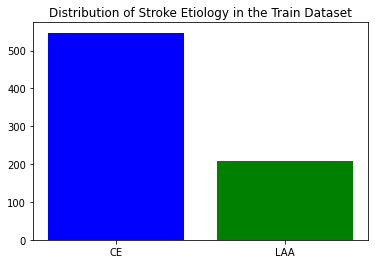

In [10]:
# visualize distribution
plt.bar(['CE', 'LAA'], [547, 207], color=['b', 'g'])
plt.title('Distribution of Stroke Etiology in the Train Dataset')

The distribution is almost 2:1 in favor of CE.

Now, visualize the number of images of clots obtained from the same patient (image_num) column and the distribution of how many images are taken at each center. I'm adapting some visualization efforts used by Robert Kwiatkowski in this competition in his first section, "Images metadata", which can be found [here](https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration). 

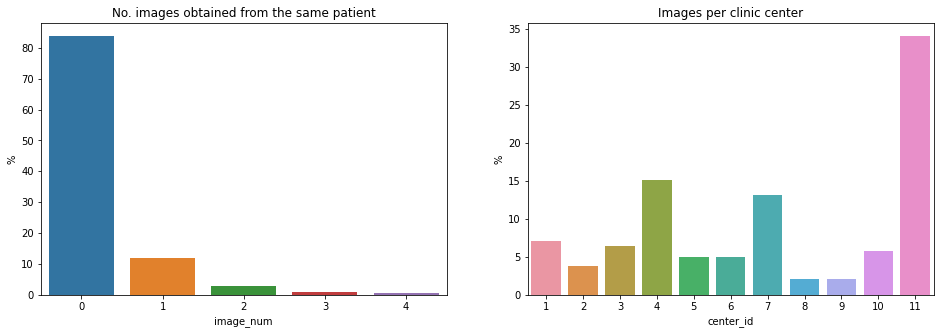

In [11]:
# group data together for both categories and plot with Seaborn

# group data
p_no = train_df.groupby('image_num')['image_num'].count().div(len(train_df)).mul(100)
c_no = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

# plot
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=p_no.index, y=p_no.values, ax=ax[0])
ax[0].set_title("No. images obtained from the same patient"), ax[0].set_ylabel("%")
sns.barplot(x=c_no.index, y=c_no.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

Clinic 11 represents around 35% of the total images. Centers 8 & 9 have a low concentration of images in the dataset with only about 2% each. Around 10% of the images are clots from patients that are already represented with a picture of another clot in the dataset. 

## Preview some images

Let's take a look at some of the images in the train set.

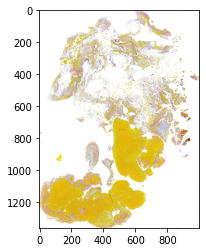

In [12]:
from PIL import Image
images = []

# png file type in train folder
for filename in glob.glob('/content/drive/MyDrive/Flatiron/Capstone/train_images/*.png'):
    im=Image.open(filename)
    images.append(im)

plt.imshow(images[0])

Here's the first image. Let's check out the metadata of the images list for a quick sanity check, and also check out some more of the images.

In [13]:
# check out data types for the image list and individual images
i_l_t = type(images)     # type for images list
i_t = type(images[4])     # type for an image in the image list

# look at size of the list- should be 754. I know it will be 752- I'll fix later
i_l_s = len(images)

# print out meta findings
print(f"Type of image list: {i_l_t}")
print(f"Type of image in the list: {i_t}")
print(f"Number of images in the set: {i_l_s}")

Type of image list: <class 'list'>
Type of image in the list: <class 'PIL.PngImagePlugin.PngImageFile'>
Number of images in the set: 752


Images are png type, but there are only 752 of them, even though there are 754 in the original dataset. This discrepancy is because I am using a modified dataset from the original Kaggle competition. I am using a dataset from Jirka Borovec who converted the original iamges with .tif type and reduced the size of the images through a technique to reduce empty background space. These images are .png type and they compose the folder found in my train_path. The link to the dataset is [here](https://www.kaggle.com/datasets/jirkaborovec/stroke-blood-clot-origin-1k-scale-bg-crop).

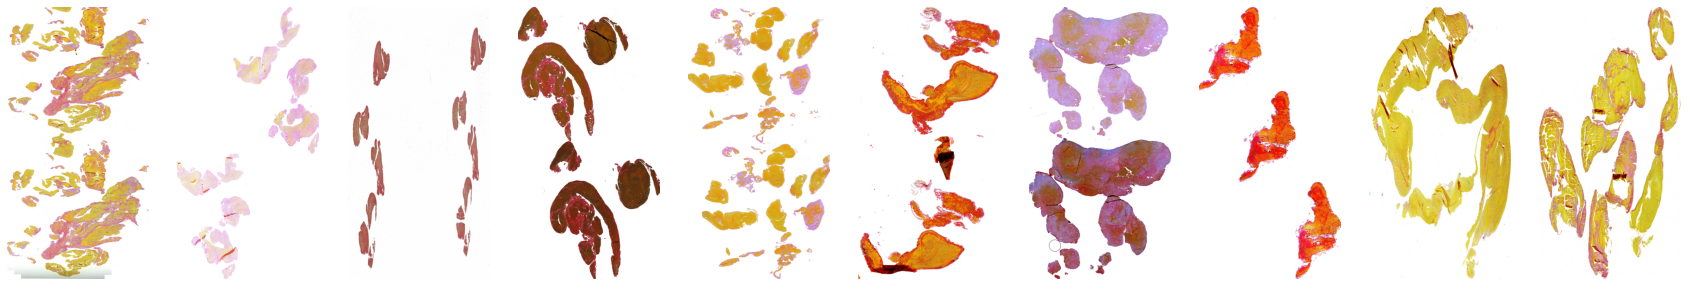

In [14]:
# Look at some more images in the train set:

# Generate list of 10 different random numbers from 0-751
import random
r_l = random.sample(range(0, 751), 10)     # sample with replacement

fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(10):
  ax[i].imshow(images[r_l[i]])     # show image at the random index
  ax[i].axis('off')
  ax[i].set_aspect('auto')

plt.show()

It seems like a lot of these images are mirrored. But I think what's occurring here is that the cross-sectional area of each clot is scanned on both sides; or it might be the case that each individual fragment is cut, and multiple cross-sectional areas of the same clot are scanned.

## Clean the dataset
Steps to take:
1. There are several images that should be removed from the dataset because they are very smooth. The resolution of these images are very low and may reduce success of any future prediction algorithm created in this project. The IDs of these images are found from a Kaggle discussion on this project [here](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/discussion/338256), and they include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
2. There are two images that are described in the train metadata but not in the train images. I am going to find the IDs of these two missing images and remove them from the train csv (metadata) because I will have to associate each image with labels from the train csv file, and the presence of additional labels may interfere with that process as well as other, further exploration of train metadata.

In [15]:
# I want to create a list or df column of string type data that contains all the 
# names (IDs) of each individual image.
t_img_ids = os.listdir(train_path)
print(len(t_img_ids))
print(t_img_ids[5])

752
098f15_0.png


Recall the '.png' ending for each of these images. Remove these endings for ease later when I find the missing entries.

In [16]:
# loop through images in t_img_ids and remove .png ending
train_img_ids = []     # new list to append altered objects

for i_id in t_img_ids:
  new_id = i_id[:-4]
  # train_img_ids.append(i_id.removesuffix('.png'))
  train_img_ids.append(new_id)

# preview one of the altered list items for a quick sanity check
train_img_ids[82]

'24f8f5_0'

In [17]:
# get list of image ids in the train csv file
train_df_ids = train_df.image_id.to_list()

# get the missing elements through set subtraction
missing_imgs = list(set(train_df_ids) - set(train_img_ids))
missing_imgs

['6baf51_0', 'b894f4_0']

So, the images to clean out of the train_csv file include: b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
The images to remove from the train image dataset include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.

In [18]:
# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# length should be 748
len(train_df)

748

In [19]:
# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

# check the modified dataframe
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


Looks good. Now, move on to clean the image folder. To reiterate from above, remove images with these IDs: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0. I will be copying the image dataset in my Google Drive, removing these images, and then calling this new file path for train_path.

In [20]:
# redefine train_path
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned'

# check if the images were actually removed - length should be 748
len(os.listdir(train_path))

748

## Create dataframe with labeled images
Creating this dataframe will allow for previewing labeled images and it will also allow me to more easily split the data into train and test categories.

Make sure that the image IDs in my image folder are the same as the image IDs in the CSV file so that I can make sure I am working with the exact same data. This step will ensure accurate labels later.

In [21]:
# first, check if the filenames for the image directory lines up with the csv 
# img ids

t_img_ids = os.listdir(train_path)

# loop through images in t_img_ids and remove .png ending
train_img_ids = []     # new list to append altered objects

for i_id in t_img_ids:
  new_id = i_id[:-4]
  # train_img_ids.append(i_id.removesuffix('.png'))
  train_img_ids.append(new_id)

# create object with train csv file image ids
csv_ids = train_df.image_id.to_list()

# sort the lists
train_img_ids.sort()
csv_ids.sort()

# check if the lists are the same
if train_img_ids == csv_ids:
  print('The lists are the same')
else:
  print ('F')

The lists are the same


In [22]:
# create new df
df_all = train_df.copy()
df_all = df_all.drop(['center_id', 'patient_id', 'image_num'], axis=1)

# change 'label' column to contain 0 or 1. CE will be 0 & LAA will be 1
#df_all.loc[df_all['label'] == 'CE', 'label'] = 0     # CE is now 0
#df_all.loc[df_all['label'] == 'LAA', 'label'] = 1     # LAA is now 1

print(len(df_all))
df_all.head()

748


,image_id,label
0,006388_0,CE
1,008e5c_0,CE
2,00c058_0,LAA
3,01adc5_0,LAA
4,026c97_0,CE


In [23]:
# change image_id to image_path

# define strings to append to front and back of image ids
s_app = '/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned/'
s_suff = '.png'

img_id_list = df_all.image_id.to_list()
img_paths_cleaned = [s_app + img_id + s_suff for img_id in img_id_list]

df_all['image_path'] = img_paths_cleaned

# remove image_id and keep image_path
df_all = df_all.drop('image_id', axis=1)

df_all.head()

,label,image_path
0,CE,/content/drive/MyDrive/Flatiron/Capstone/train...
1,CE,/content/drive/MyDrive/Flatiron/Capstone/train...
2,LAA,/content/drive/MyDrive/Flatiron/Capstone/train...
3,LAA,/content/drive/MyDrive/Flatiron/Capstone/train...
4,CE,/content/drive/MyDrive/Flatiron/Capstone/train...


## Preview images from each category
Is it possible to simply view differences between the two etiologies? Probably not, but it's worth taking a look.



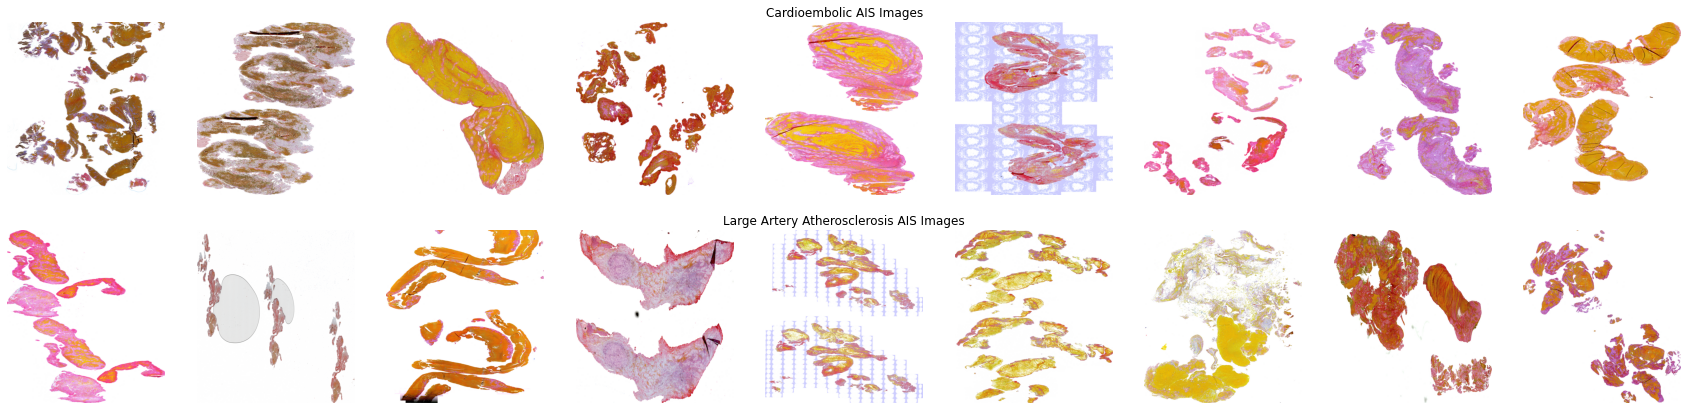

In [24]:
# Make a list of images in CE (0) category and view them
ce_img_tmp = df_all[df_all['label']=='CE']['image_path'].iloc[:9].to_list()
laa_img_tmp = df_all[df_all['label']=='LAA']['image_path'].iloc[:9].to_list()

# append the real images to list
ce_images = []
laa_images = []

# png file type in train folder
for filename in ce_img_tmp:
    im=Image.open(filename)
    ce_images.append(im)

for filename in laa_img_tmp:
    im=Image.open(filename)
    laa_images.append(im)

# plot
fig, ax = plt.subplots(2, 9, figsize=(30, 7))
for i in range(9):
  ax[0][i].imshow(ce_images[i])
  ax[1][i].imshow(laa_images[i]) 
  ax[0][i].axis('off')
  ax[0][i].set_aspect('auto')
  ax[1][i].axis('off')
  ax[1][i].set_aspect('auto')

  if i == 4:
    ax[0][i].set_title('Cardioembolic AIS Images')
    ax[1][i].set_title('Large Artery Atherosclerosis AIS Images')

plt.show()

The variation between the different CE & LAA images is pretty large. I'm not sure I can spot any major trends. There is a weird blue background on the sixth image that is in part due to the imaging technique for some of the images and in part due to the background reduction technique utilized for the images I am using in this project. There is also presence of this effect in the fifth LAA image. I'm not sure if the sac-looking entities on the second LAA image are part of the clot or if it is a result of the process of creating the image. I'm worried about losing too much resolution of these photos in comparison to the original whole slide, .tif images. There is a substantial amount of detail lost in the transition from those images to these .png images. 

# Modeling

## Prepare images for modeling & feature engineering
Use ImageDataGenerator as a feature engineering method to alter the images. This process allows for reduction in bias that may be learned by future models. For example, some of the images in the set have some sort of background likely produced by the image-scanning process. The permutations found in ImageDataGenerator allow for a reduction in such biases.

In [25]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

I have a strong feeling that I will change these or modify these permutations in some way in this project. Or I may return to the original Kaggle dataset to select .tif iamges that are higher resolution. I'm not sure if my .png pictures are able to depict some of the fine-detailed entities like platelettes, RBCs, and WBCs foudn in the blood clots.

### Split data into train and test sets

In [26]:
from sklearn.model_selection import train_test_split
df_tt = df_all.copy()
train, test = train_test_split(df_tt, test_size=0.2, random_state=42, 
                               shuffle=True)

Straightforward split... don't need to split into X_train, y_train, etc. because I am going to use the train and test dataset for permuting the images and reducing bias in the next step.

### Fit ImageDataGenerator to the datasets

Purpose of this step is to fit the ImageDataGenerator onto the images in the train and test set to reduce bias that may be learned by future models. I can't really tell the difference between the categories (CE & LAA), but the whole point of this project is to allow the computer to find these differences. That is why it is important to take some initiative to reduce bias, even if there really might not be much of a presence in this particular set. 

In [27]:
# fit the image modifier/permuter
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='image_path',
                                         y_col='label', target_size=(256,256),
                                         class_mode='binary', batch_size=13,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='image_path',
                                         y_col='label', target_size=(256,256),
                                         class_mode='binary', batch_size=15,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


The train set has 598 images and the test set has 150 images.

## Baseline model

I am adapting this code from my project dealing with detecting pneumonia from x-ray imaging, which can be found [here](https://github.com/samoliver3/dsc-phase-4-project/blob/main/index.ipynb). However, the original basis of the architecture of this model is from Francois Chollet and his blog post titled ["Building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [ ]:
# Baseline model

# trying an SGD optimizer with a low learning rate
optimizer = keras.optimizers.SGD(learning_rate=1e-6)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))    # re-scaled image size.
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# end model with sigmoid activation (great for binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',     # loss function should be binary for 2 col
    optimizer=optimizer,
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

The model is sequential with several Conv2D and MaxPooling2D layers. I did make the image size fairly small... I think. I'll need to double check that, and maybe make some changes in the ImageDataGenerator calls to permute the images. I may want to keep these bigger and with better resolution.

### Setup Callbacks for efficiency

In [28]:
# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, 
                   min_delta=0.01)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     save_best_only=True)

In [ ]:
# keep track of time used while training this model.
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# fit the model with the train generator. Use a standard approach for defining'
# the steps per epoch. (# of images for train or validation / batch size)
history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=20,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/20
46/46 [==============================] - 56s 947ms/step - loss: 0.6762 - acc: 0.7308 - val_loss: 0.6764 - val_acc: 0.7133
Epoch 2/20
46/46 [==============================] - 43s 933ms/step - loss: 0.6747 - acc: 0.7308 - val_loss: 0.6748 - val_acc: 0.7067
Epoch 3/20
46/46 [==============================] - 42s 928ms/step - loss: 0.6723 - acc: 0.7308 - val_loss: 0.6754 - val_acc: 0.7133
Epoch 4/20
46/46 [==============================] - 42s 924ms/step - loss: 0.6712 - acc: 0.7308 - val_loss: 0.6726 - val_acc: 0.7133
Epoch 5/20
46/46 [==============================] - 42s 923ms/step - loss: 0.6693 - acc: 0.7308 - val_loss: 0.6719 - val_acc: 0.7133
Epoch 6/20
46/46 [==============================] - 42s 925ms/step - loss: 0.6687 - acc: 0.7308 - val_loss: 0.6694 - val_acc: 0.7133
Epoch 7/20
46/46 [==============================] - 42s 926ms/step - loss: 0.6662 - acc: 0.7308 - val_loss: 0.6675 - val_acc: 0.7133
Epoch 8/20
46/46 [==============================] - 42s 923ms/step - 

Validation accuracy and train accuracy were absolutely stagnant the whole time. That's not the most exciting result. It probably greedily classified the images and couldn't find any other important features... Something like that.

### Evaluate model

In [ ]:
test_loss, test_acc = history.model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Acc: {test_acc}')

10/10 [==============================] - 9s 890ms/step - loss: 0.6625 - acc: 0.7133
Test Loss: 0.6625041961669922
Test Acc: 0.7133333086967468


I think it's a good idea, at least in these initial phases to aim for accuracy above around 80% or so because 71.33% is the same as just guessing CE everytime in the test set. Around a 9% gain in that would give me some confidence to iterate on a model and make improvements that are largely in respect to loss (like the evaluation metric used for this Kaggle comp) or maybe even just accuracy or an F1 score. 

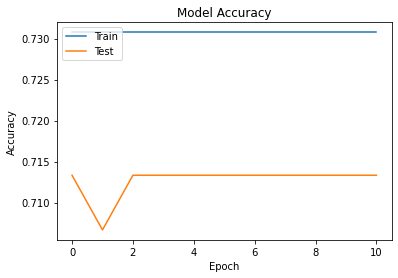

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Flat the whole time... roughly looks like the fraction of CE to whole quantity of images for each set. Model is probably classifying everything as CE.

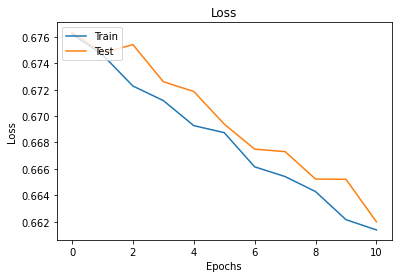

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Based on the graphs, I have a suspicion that the model is simply predicting everything as 'CE'.

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)
y_hat_tmp

array([[0.46205994],
       [0.4664525 ],
       [0.45575508],
       [0.45594504],
       [0.45600408],
       [0.46297526],
       [0.46589607],
       [0.45870247],
       [0.46205232],
       [0.4507638 ],
       [0.46928027],
       [0.46892837],
       [0.4678556 ],
       [0.46724805],
       [0.45004866],
       [0.4684915 ],
       [0.45970654],
       [0.46794423],
       [0.45619756],
       [0.472781  ],
       [0.4611898 ],
       [0.46961433],
       [0.4518835 ],
       [0.45936492],
       [0.46158168],
       [0.4587564 ],
       [0.4671242 ],
       [0.45249826],
       [0.46828854],
       [0.45998943],
       [0.4652118 ],
       [0.45830333],
       [0.47201887],
       [0.46701127],
       [0.46084177],
       [0.4614615 ],
       [0.458984  ],
       [0.46032423],
       [0.4666128 ],
       [0.46713132],
       [0.45796075],
       [0.4717441 ],
       [0.45067963],
       [0.46224675],
       [0.4642054 ],
       [0.46449175],
       [0.4609708 ],
       [0.468

Seems like the first model is predicting everything as Cardioembolic.

In [ ]:
print(len(test.loc[test.label=='LAA']))
len(test.loc[test.label=='CE'])

43


107

Testing to see if the first model actually did predict everything as CE.

In [ ]:
107/(43+107)*100

71.33333333333334

I'm going to carry out some evaluation of the baseline model. First, cast CE & LAA categories to numbers (0 or 1), then use that for calculations involved in confusion matrix and classification report.

In [ ]:
df_test_tmp = test.copy()
df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

df_test_tmp.head(10)

,label,image_path
580,0,/content/drive/MyDrive/Flatiron/Capstone/train...
356,0,/content/drive/MyDrive/Flatiron/Capstone/train...
133,1,/content/drive/MyDrive/Flatiron/Capstone/train...
250,0,/content/drive/MyDrive/Flatiron/Capstone/train...
299,1,/content/drive/MyDrive/Flatiron/Capstone/train...
388,0,/content/drive/MyDrive/Flatiron/Capstone/train...
336,1,/content/drive/MyDrive/Flatiron/Capstone/train...
155,0,/content/drive/MyDrive/Flatiron/Capstone/train...
527,0,/content/drive/MyDrive/Flatiron/Capstone/train...
734,1,/content/drive/MyDrive/Flatiron/Capstone/train...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


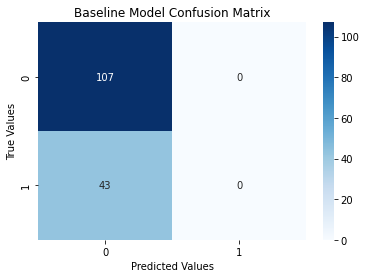

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = df_test_tmp.label.astype(int)

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

If it wasn't clear before, it should be absolutely clear what the model did in the first attempt...

In [ ]:

print(classification_report(y_t, y_hat))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       107
           1       0.00      0.00      0.00        43

    accuracy                           0.71       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.51      0.71      0.59       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Helper functions for evaluating models

List of what I want to be evaluated:
1. Test accuracy and loss
2. Graphs of loss and accuracy for test and train set - important for observation of convergence.
3. Confusion matrix for predicted values of the test set and true values.
4. I might as well print a classification report just in case I decide to use any other metrics in the future for evaluation (like F1).

In [29]:
def eval(history, model, test_gen, test_set):
  # print loss and accuracy of the model on the test set
  test_loss, test_acc = history.model.evaluate(test_gen)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

  # create plots for accuracy and loss
  fig, ax = plt.subplots(1, 2, figsize = (12,8))
  ax[0].plot(history.history['acc'])
  ax[0].plot(history.history['val_acc'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(['Train', 'Test'], loc='upper left')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['Train', 'Test'], loc='upper left')

  plt.show()

  # create df with integer labels instead of CE or LAA to use soon.
  df_test_tmp = test.copy()
  df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
  df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

  # plot confusion matrix - create predictions for the model
  y_hat_tmp = history.model.predict(test_gen)

  # classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
  thresh = 0.5
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
  y_t = df_test_tmp.label.astype(int)
  cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

  # plot confusion matrix values
  sns.heatmap(
      cm_vals, 
      annot=True, 
      cmap='Blues', 
      fmt='0.5g'
  )
  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  plt.title('Baseline Model Confusion Matrix')
  plt.show()

  # display classification report
  print(classification_report(y_t, y_hat))

## VGG-19 model

### Create and fit the model

In [ ]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
     weights='imagenet',
     input_shape=(256, 256, 3),
     # Don't include ImageNet classifier at top b/c input_shape is changed
     include_top=False 
)

vgg_params.trainable = False     # freeze the base model

# create sequential model, add VGG-19 frozen base model, then add more layers
model = models.Sequential()
model.add(vgg_params)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# define optimizer
opt = keras.optimizers.Adam(learning_rate=1e-6)

# Compile the model
model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['acc']
)

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,121,665
Trainable params: 2,097,281
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
46/46 [==============================] - 44s 938ms/step - loss: 0.8345 - acc: 0.6271 - val_loss: 0.7249 - val_acc: 0.7133
Epoch 2/50
46/46 [==============================] - 43s 943ms/step - loss: 0.6034 - acc: 0.7308 - val_loss: 0.6375 - val_acc: 0.7133
Epoch 3/50
46/46 [==============================] - 42s 915ms/step - loss: 0.5805 - acc: 0.7308 - val_loss: 0.6595 - val_acc: 0.7133
Epoch 4/50
46/46 [==============================] - 42s 915ms/step - loss: 0.5097 - acc: 0.7308 - val_loss: 0.6532 - val_acc: 0.7133
Epoch 5/50
46/46 [==============================] - 43s 930ms/step - loss: 0.4948 - acc: 0.7308 - val_loss: 0.5854 - val_acc: 0.7133
Epoch 6/50
46/46 [==============================] - 43s 931ms/step - loss: 0.4686 - acc: 0.7625 - val_loss: 0.5837 - val_acc: 0.7267
Epoch 7/50
46/46 [==============================] - 43s 928ms/step - loss: 0.4715 - acc: 0.7960 - val_loss: 0.6707 - val_acc: 0.7133
Epoch 8/50
46/46 [==============================] - 42s 923ms/step - 

### Evaluate model

In [ ]:
# evaluate the best model epoch
from keras.models import load_model
saved_model = load_model('best_model.h5')

10/10 [==============================] - 9s 909ms/step - loss: 0.6829 - acc: 0.7067
Test Loss: 0.6828871369361877
Test Acc: 0.7066666483879089


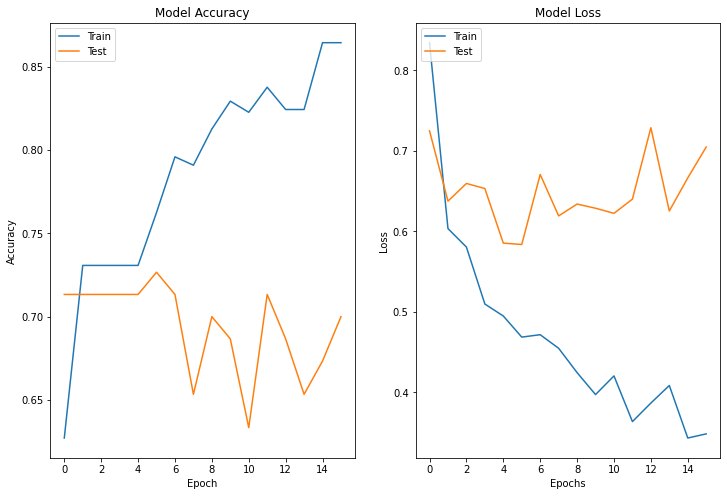

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


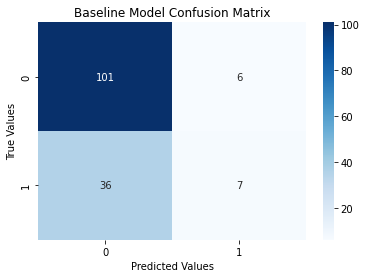

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       107
           1       0.54      0.16      0.25        43

    accuracy                           0.72       150
   macro avg       0.64      0.55      0.54       150
weighted avg       0.68      0.72      0.66       150



In [ ]:
eval(history, saved_model, test_gen, test)

This time around, VGG-19 is maybe doing a little more than just guessing, but it's still not an ideal situation. There's no convergence between the test and train set for loss or accuracy, and the metrics are not as great as I would like to see. I think I should also start testing performance against a loss formula similar to that of which will be used in the Kaggle competition. I think some tweaking, especially with how image permutations are handled, and maybe even loading in the .tif files from the original train set will help with improving performance. I will also look into some other algorithms to use for this project.

## Prepare images for modeling & FE
Going to shoot for larger image sizes and maybe change the image modification strategy.

In [30]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    #rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

# fit the image modifier/permuter
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='image_path',
                                         y_col='label', target_size=(512,512),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='image_path',
                                         y_col='label', target_size=(512,512),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


## VGG-19 2nd attempt

### Create and fit the model

In [ ]:
# Setup some Callbacks for improved efficiency

# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, 
                   min_delta=0.01)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     save_best_only=True)

In [ ]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
     weights='imagenet',
     input_shape=(512, 512, 3),
     # Don't include ImageNet classifier at top b/c input_shape is changed
     include_top=False 
)

vgg_params.trainable = False     # freeze the base model

# create sequential model, add VGG-19 frozen base model, then add more layers
model = models.Sequential()
model.add(vgg_params)
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# adding dropout layer
model.add(Dropout(0.25))
model.add(Dense(1))

# define optimizer
opt = keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model
model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['acc']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,801,857
Trainable params: 16,777,473
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
37/37 [==============================] - 71s 2s/step - loss: 11.0075 - acc: 0.2766 - val_loss: 10.9074 - val_acc: 0.2847
Epoch 2/50
37/37 [==============================] - 69s 2s/step - loss: 11.2404 - acc: 0.2629 - val_loss: 10.9074 - val_acc: 0.2847
Epoch 3/50
37/37 [==============================] - 69s 2s/step - loss: 11.1094 - acc: 0.2715 - val_loss: 10.8015 - val_acc: 0.2917
Epoch 4/50
37/37 [==============================] - 68s 2s/step - loss: 11.1618 - acc: 0.2680 - val_loss: 10.8015 - val_acc: 0.2917
Epoch 5/50
37/37 [==============================] - 67s 2s/step - loss: 11.1356 - acc: 0.2698 - val_loss: 10.8015 - val_acc: 0.2917
Epoch 6/50
37/37 [==============================] - 68s 2s/step - loss: 11.1880 - acc: 0.2663 - val_loss: 11.0133 - val_acc: 0.2778
Epoch 7/50
37/37 [==============================] - 68s 2s/step - loss: 11.2142 - acc: 0.2646 - val_loss: 10.8015 - val_acc: 0.2917
Epoch 8/50
37/37 [==============================] - 68s 2s/step - loss: 11.1

### Evaluate the model

10/10 [==============================] - 14s 1s/step - loss: 10.8778 - acc: 0.2867
Test Loss: 10.877789497375488
Test Acc: 0.2866666615009308


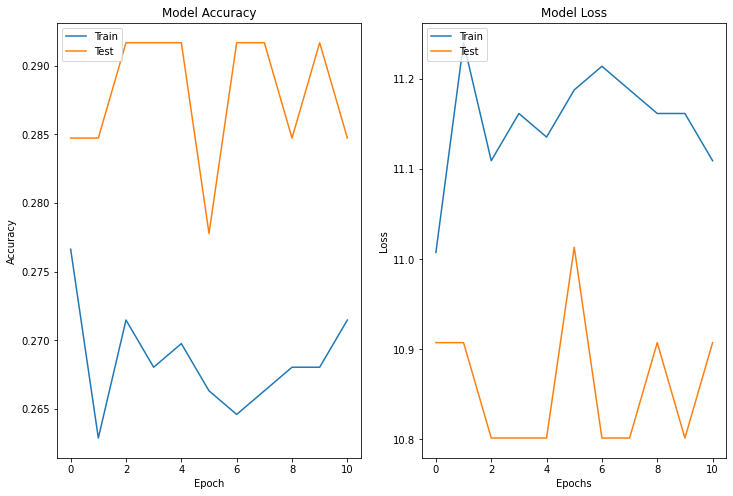

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


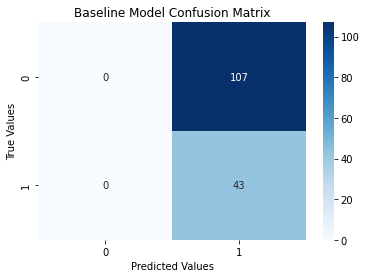

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.29      1.00      0.45        43

    accuracy                           0.29       150
   macro avg       0.14      0.50      0.22       150
weighted avg       0.08      0.29      0.13       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
eval(history, saved_model, test_gen, test)

I have a feeling that the models are not doing well simply because there is not enough information in the pictures do to lack of quality. I am going to try to use the whole slide images from the original dataset.

## Import wholeslide images from original dataset

### Installing openslide to read images

Had issues installing openslide package, but there is a workaround for installing it below. Some googling may be involved to download openslide if the generic "import openslide" command does not work.

In [31]:
!pip uninstall setuptools
!pip install setuptools=v45.3.0
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

import openslide

ERROR: Invalid requirement: 'setuptools=v45.3.0'
Hint: = is not a valid operator. Did you mean == ?
Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-openslide is already the newest version (1.1.1-2ubuntu4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import OpenSlide to allow for images to be easily read later. Also, appending paths to train df.

In [32]:
from openslide import OpenSlide

# going to create train dataframe with the wholeslide image paths
train_df["file_path"] = train_df["image_id"].apply(
    lambda x: "/content/drive/MyDrive/Flatiron/Capstone/train/" + x + ".tif")

In [33]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,/content/drive/MyDrive/Flatiron/Capstone/train...
1,008e5c_0,11,008e5c,0,CE,/content/drive/MyDrive/Flatiron/Capstone/train...
2,00c058_0,11,00c058,0,LAA,/content/drive/MyDrive/Flatiron/Capstone/train...
3,01adc5_0,11,01adc5,0,LAA,/content/drive/MyDrive/Flatiron/Capstone/train...
4,026c97_0,4,026c97,0,CE,/content/drive/MyDrive/Flatiron/Capstone/train...


### Preview some images

In [ ]:
sample_train = train_df[:4]

for i in range(4):
    slide = OpenSlide(sample_train.loc[i, "file_path"])
    region = (0, 0)
    size = (10000, 10000)
    region = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(region)
    plt.show()